In [1]:
import jax
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad
from jax.experimental import optimizers,stax
from jax.experimental.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax,BatchNorm,Dropout
from jax.experimental.optimizers import optimizer, make_schedule, exponential_decay
#from jax.ops import index, index_update

import itertools
from functools import partial
from tqdm import trange
from torch.utils import data
import matplotlib.pyplot as plt

from scipy.integrate import odeint

from jax.nn import sigmoid,relu,log_sigmoid,one_hot
from jax.lax import scan
import h5py
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
import functools
import operator as op

from jax import lax
from jax import random
import jax.numpy as jnp

from jax.nn import (relu, log_softmax, softmax, softplus, sigmoid, elu,
                    leaky_relu, selu, gelu)
from jax.nn.initializers import glorot_normal, normal, ones, zeros

In [3]:
# author:https://github.com/google/jax/pull/1496/commits/63fd3cbf9b873c80cd30737dcdfd940171a800cc
def DepthwiseConv(dimension_numbers, out_chan, filter_shape,
                    strides=None, padding='VALID', W_init=None,
                    b_init=normal(1e-6)):
    lhs_spec, rhs_spec, out_spec = dimension_numbers
    one = (1,) * len(filter_shape)
    strides = strides or one
    W_init = W_init or glorot_normal(rhs_spec.index('I'), rhs_spec.index('O'))

    def init_fun(rng, input_shape):
      filter_shape_iter = iter(filter_shape)
      kernel_shape = [out_chan * input_shape[lhs_spec.index('C')] if c == 'O'
                      else 1 if c == 'I'
                      else next(filter_shape_iter) for c in rhs_spec]
      output_shape = lax.conv_general_shape_tuple(
          input_shape, kernel_shape, strides, padding, dimension_numbers)
      bias_shape = [out_chan * input_shape[lhs_spec.index('C')] if c == 'C'
                    else 1 for c in out_spec]
      bias_shape = tuple(itertools.dropwhile(lambda x: x == 1, bias_shape))
      k1, k2 = random.split(rng)
      W, b = W_init(k1, kernel_shape), b_init(k2, bias_shape)
      return output_shape, (W, b)
    def apply_fun(params, inputs, **kwargs):
        W, b = params
        return lax.conv_general_dilated(inputs, W, strides, padding, one, one, dimension_numbers, 
                                        feature_group_count=inputs.shape[lhs_spec.index('C')]) + b

    return init_fun, apply_fun

DepthwiseConv2D = functools.partial(DepthwiseConv, ('NHWC', 'HWIO', 'NHWC'))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm/ np.sum(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
from keras.datasets import cifar10
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [7]:
x_train=np.asarray(x_train)
x_test=np.asarray(x_test)

In [8]:
x_train=x_train/255.
num_classes=y_train.max()+1
y_train=y_train.flatten()
y_train=one_hot(y_train,num_classes)

print(x_train.shape)
print(y_train.shape)

train_dataset = DataGenerator(x_train, y_train, batch_size=128)

(50000, 32, 32, 3)
(50000, 10)


In [9]:
# Architecture
def CNN():
    init, apply = stax.serial(DepthwiseConv2D(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              DepthwiseConv2D(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              DepthwiseConv2D(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),Dropout(0.9,mode='train'),Flatten,
                              Dense(120), Relu, 
                              Dense(84), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [10]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_key, (128,32,32,3))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch,it):
        images, labels = batch
        outputs = self.net_apply(params, images,rng=random.PRNGKey(it))
        loss = -labels*np.log(outputs+1e-7)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch, i)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch,it)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs,rng=random.PRNGKey(0))
        return outputs

In [11]:
# Initialize model
model = CNNclassifier()

In [12]:
x_test=x_test[0:1000]/255.
num_classes=y_test.max()+1
y_test=y_test[0:1000].flatten()
y_test=one_hot(y_test,num_classes)
x_test=np.asarray(x_test)
test_dataset = DataGenerator(x_test, y_test, batch_size=128)

In [13]:
# Architecture
def CNN_test():
    init, apply = stax.serial(DepthwiseConv2D(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              DepthwiseConv2D(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              DepthwiseConv2D(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),Dropout(0.9,mode='test'),Flatten,
                              Dense(120), Relu, 
                              Dense(84), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [14]:
test_init,test_apply=CNN_test()

100%|██████████| 10/10 [00:05<00:00,  1.90it/s, Loss=0.22976843]


Text(0, 0.5, 'Loss')

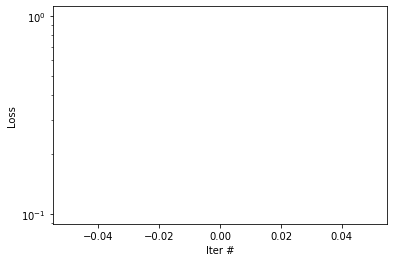

In [15]:
# Train model
model.train(train_dataset, nIter=10)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [16]:
def predict(params, inputs):
  outputs = test_apply(params, inputs,rng=random.PRNGKey(0))
  return outputs

In [17]:
print(x_test.shape)
print(y_test.shape)

(1000, 32, 32, 3)
(1000, 10)


In [18]:
# Compute classification accuracy on the entire test data-set
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (x_test, y_test))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 10.200000762939453%
